In [17]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkFiles
import pandas as pd
import numpy as np
import requests
from IPython.display import HTML
from transformers import LongformerForMaskedLM, LongformerTokenizer, BertForPreTraining, BertTokenizer, AutoTokenizer
import seaborn as sn
import matplotlib.pyplot as plt
from datasets import Dataset
import pyspark_huggingface

In [18]:
#Test run with Reuters dataset
from pyspark.sql.functions import length
spark = SparkSession.builder.appName("ReutersNews").getOrCreate()
dataset = "danidanou/Reuters_Financial_News"

iframe_html = """
<iframe src="https://huggingface.co/datasets/{dataset}/embed/viewer" width="80%" height="560px"></iframe>
""".format(dataset=dataset)

#Loading Reuters Data into Spark

HUGGING_FACE_PARQUET_API = "https://huggingface.co/api/datasets/{dataset}/parquet"
r = requests.get(HUGGING_FACE_PARQUET_API.format(dataset=dataset))

train_parquet_files = r.json()['default']['train']

for url in train_parquet_files:
    spark.sparkContext.addFile(url)

df = spark.read.parquet(SparkFiles.getRootDirectory() + "/*.parquet")




df = df.withColumn("Article_length", length(df["Article"]))



25/06/17 18:25:56 WARN SparkContext: The path https://huggingface.co/api/datasets/danidanou/Reuters_Financial_News/parquet/default/train/0.parquet has been added already. Overwriting of added paths is not supported in the current version.


/Users/cristianzuniga/Library/Python/3.10/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 2400x600 with 0 Axes>

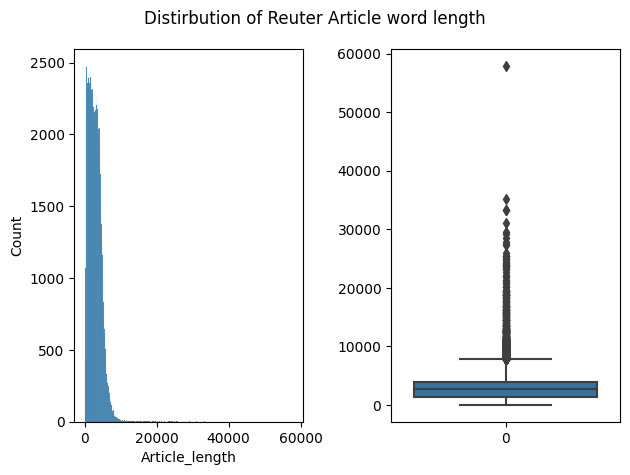

In [19]:

plt.figure(figsize=(24,6))

fig, axs = plt.subplots(ncols=2)


article_length_series = df.select("Article_length").toPandas().squeeze()


fig.suptitle('Distirbution of Reuter Article word length')

sn.histplot(data=article_length_series, ax=axs[0])

sn.boxplot(data=article_length_series, ax=axs[1])
plt.tight_layout()
plt.show()

In [20]:
#We'll do 3 methods the first will be to take the first 512 words of an article (if it has it), combine into a column for a dataframe
#The second method will be to take the middle 512 words (if available) of an article and combine into a column
#The third will be to take the first 2000 words of an article, combine into a column 

from pyspark.sql.functions import substring, col, expr
from pyspark.sql.types import IntegerType

word_df = df.filter("Article_length >= 512")

#Method one
first_512_df = word_df.withColumn("first_512", substring("Article", 1, 512)).select("first_512")

#Method two

#Making a function to define middle of column

middle_512_df = word_df.withColumn(
    "middle_512",
    expr("substring(Article, (Article_length - 512) / 2, Article_length - (Article_length - 512) / 2)")
).select("middle_512")

#Third_method
word_df = df.filter("Article_length <= 4096")

first_4096_df = word_df.withColumn("first_4096", substring("Article", 1, 4096)).select("first_4096")






In [21]:
#The third method will feed into a longform tranfsformer for pretraining
#The second method and first method will feed into a standard bert for pretraining
#We'll use a one lstm that will train on the first 512 words (benchmark, to be added later)


#Importing the models


#The longformer model
lf_tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
lf_model = LongformerForMaskedLM.from_pretrained("allenai/longformer-base-4096")


#Bert model
bert_tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")



(06/17/25)
The step below could use optimzation 

In [23]:
datasets_pd = {
    'first_512': first_512_df.toPandas(),
    'middle_512': middle_512_df.toPandas(), 
    'first_4096': first_4096_df.toPandas()
}
#standardizing text name col
for df in datasets_pd.keys():
    datasets_pd[df][df] = datasets_pd[df]['text']
    
    
# Tokenize
datasets_hf = {
    name: Dataset.from_pandas(df) 
    for name, df in datasets_pd.items()
}
configs = [
    {'name': 'first_512', 'tokenizer': bert_tokenizer, 'max_length': 512},
    {'name': 'middle_512', 'tokenizer': bert_tokenizer, 'max_length': 512},
    {'name': 'first_4096', 'tokenizer': lf_tokenizer, 'max_length': 4096}
]


tokenized_datasets = {}
for config in configs:
    tokenized_datasets[config['name']] = datasets_hf[config['name']].map(
        lambda examples: config['tokenizer'](
            examples['text'],  # adjust column name as needed
            truncation=True,
            padding='max_length',
            max_length=config['max_length'],
            return_tensors='pt'
        ),
        batched=True
    )

Map:   0%|          | 0/97466 [00:00<?, ? examples/s]

Map:   0%|          | 0/97466 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [ ]:
#Training the three model
training_args = TrainingArguments(
    output_dir="my_awesome_eli5_mlm_model",
    eval_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

for model in [LongformerForMaskedLM, BertForPreTraining]:
    trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer)
    